# GTSRB

Inspired by Ryan Pham's Notebook

# About Dataset
## Context
The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database

In [1]:
!pip install kaggle # Install Kaggle API
!mkdir ~/.kaggle # Create directory

# Create API token
# Enter name and API key
with open("/root/.kaggle/kaggle.json", "w+") as f:
  f.write('{"username":"thaoduong84","key":"42c620fe61fbd50c5f552b99c0fbe2e7"}')

!chmod 600 ~/.kaggle/kaggle.json # Set permissions
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign # API call to download

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
100% 609M/612M [00:05<00:00, 76.4MB/s]
100% 612M/612M [00:05<00:00, 117MB/s] 


In [2]:
! mkdir gtsrb-german-traffic-sign
! unzip gtsrb-german-traffic-sign.zip -d gtsrb-german-traffic-sign

Streaming output truncated to the last 5000 lines.
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00010.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00011.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00012.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00013.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00014.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00015.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00016.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00017.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00018.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00019.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00020.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00021.png  
  inflating: gtsrb-german-traffic-sign/train/5/00005_00053_00022.png  
  inflating: gtsrb-german-

# Load Libraries

In [3]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Sampler
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# GTSRB Dataset Class

In [4]:
class MyGTSRBset(Dataset):
  def __init__(self, lablecsv, transform = None):
    csvread = pd.read_csv(lablecsv)
    self.image_files = []
    self.imagelables = csvread['ClassId']
    self.transform = transform
    imagepaths = csvread['Path']
    for imagepath in imagepaths:
      imagepath = 'gtsrb-german-traffic-sign/' + imagepath
      self.image_files.append(imagepath)

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    imagepath = self.image_files[idx]
    image = Image.open(imagepath)
    if self.transform:
      image = self.transform(image)


    return image, self.imagelables[idx]


# Exploring the dataset

16 

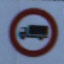

1 

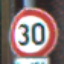

38 

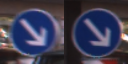

33 

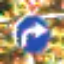

11 

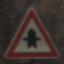

18 

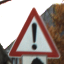

12 

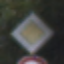

25 

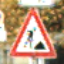

35 

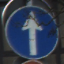

20 

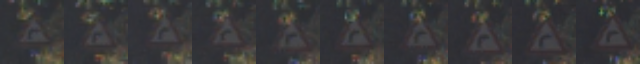

In [7]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow  # Use this for displaying images in Google Colab

def showimg(dataset):
    mydict = dict()

    for i in range(10):
        label = dataset.__getitem__(i)[1]  # Access the label
        if label in mydict:
            mydict[label].append(dataset.__getitem__(i)[0])  # Append image
        else:
            mydict[label] = [dataset.__getitem__(i)[0]]  # Initialize list with the image

    for key in mydict.keys():
        image = []
        for img in mydict[key]:
            img = np.array(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR
            img = cv2.resize(img, (64, 64))  # Resize image
            image.append(img)
        images = np.hstack(image)  # Horizontally stack images
        print(key, end=" ")
        cv2_imshow(images)  # Display the images

# Assuming testdataset_explore and traindataset_explore are defined
showimg(testdataset_explore)
showimg(traindataset_explore)


In [8]:
# Testing Dataset Class
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor()
])
testdataset = MyGTSRBset('gtsrb-german-traffic-sign/Test.csv', transform)
traindataset = MyGTSRBset('gtsrb-german-traffic-sign/Train.csv', transform)

print(traindataset[0][0].shape)
print()
print(traindataset[0][1].shape)
print(testdataset[0][0].shape)
print(testdataset[0][1].shape)

torch.Size([3, 28, 28])

()
torch.Size([3, 28, 28])
()


# Designing MLP Architecture

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Sampler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
print(model)

Using cpu device
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2352, out_features=400, bias=True)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=200, bias=True)
    (4): ReLU()
    (5): Linear(in_features=200, out_features=100, bias=True)
    (6): ReLU()
    (7): Linear(in_features=100, out_features=50, bias=True)
  )
)


In [10]:
# Cross Entropy Loss Function and Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training

In [11]:
def evaluate(data_loader, model, criterion, list_loss, list_acc, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0

    with torch.set_grad_enabled(is_train):
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

            # Count Deviations <= 0.5 which is from normalized target value
            total_correct += (torch.argmax(output, dim=1) == target).sum().item()

            if is_train:
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

    avg_loss = total_loss / num_batches
    accuracy = total_correct / num_items

    list_loss.append(avg_loss)
    list_acc.append(accuracy)
    if is_train:

      print(f"Average loss: {avg_loss:.7f}, accuracy: {accuracy:.2%}")

    else:
      print(f"Test Average loss: {avg_loss:.7f}, accuracy: {accuracy:.2%}")

def train(data_loader, model, criterion, optimizer, loss, acc):
    evaluate(data_loader, model, criterion, loss, acc, is_train=True)

def test(data_loader, model, criterion, loss, acc):
    evaluate(data_loader, model, criterion, loss, acc, is_train=False)

In [12]:
traindataloader = DataLoader(traindataset, batch_size=64, shuffle=True)
testdataloader = DataLoader(testdataset, batch_size=64, shuffle=False)


In [13]:
for X, y in traindataloader:
    print(f"Shape of X_train [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y_train: {y.shape} {y.dtype}")
    break

Shape of X_train [N, C, H, W]: torch.Size([64, 3, 28, 28]) torch.float32
Shape of y_train: torch.Size([64]) torch.int64


In [14]:
for X, y in testdataloader:
    print(f"Shape of X_test [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y_test: {y.shape} {y.dtype}")
    break

Shape of X_test [N, C, H, W]: torch.Size([64, 3, 28, 28]) torch.float32
Shape of y_test: torch.Size([64]) torch.int64


In [15]:
%%time

epochs = 50
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(traindataloader, model, criterion, optimizer, train_loss, train_acc)
    print(f"Testing epoch: {epoch+1}")
    test(testdataloader, model, criterion, test_loss, test_acc)

Training epoch: 1
Average loss: 2.0560467, accuracy: 41.41%
Testing epoch: 1
Test Average loss: 1.4426830, accuracy: 55.71%
Training epoch: 2
Average loss: 0.9635273, accuracy: 71.14%
Testing epoch: 2
Test Average loss: 1.0731580, accuracy: 70.59%
Training epoch: 3
Average loss: 0.6695438, accuracy: 80.18%
Testing epoch: 3
Test Average loss: 1.0168136, accuracy: 73.86%
Training epoch: 4
Average loss: 0.5130669, accuracy: 84.93%
Testing epoch: 4
Test Average loss: 0.9824489, accuracy: 77.28%
Training epoch: 5
Average loss: 0.4474728, accuracy: 86.60%
Testing epoch: 5
Test Average loss: 0.8613585, accuracy: 80.88%
Training epoch: 6
Average loss: 0.3709516, accuracy: 89.06%
Testing epoch: 6
Test Average loss: 0.9180272, accuracy: 80.33%
Training epoch: 7
Average loss: 0.3194117, accuracy: 90.44%
Testing epoch: 7
Test Average loss: 1.0006492, accuracy: 79.79%
Training epoch: 8
Average loss: 0.2961041, accuracy: 91.07%
Testing epoch: 8
Test Average loss: 1.1615043, accuracy: 78.79%
Training

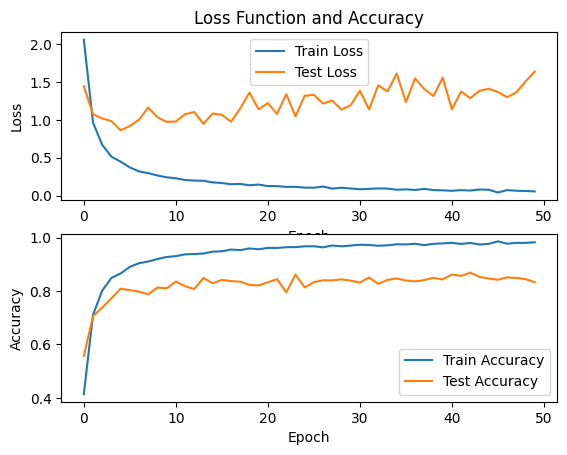

Final Train Accuracy: 98.27%
Final Test Accuracy: 83.30%


In [16]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(train_loss, label='Train Loss')
ax1.plot(test_loss, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Function and Accuracy')
ax1.legend()

ax2.plot(train_acc, label='Train Accuracy')
ax2.plot(test_acc, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

print(f"Final Train Accuracy: {train_acc[-1]:.2%}")
print(f"Final Test Accuracy: {test_acc[-1]:.2%}")